In [3]:
# Requires transformers>=4.51.0

import torch
import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel


# 取最后一个token的embedding作为整个句子的embedding
def last_token_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]


def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery:{query}'


def tokenize(tokenizer, input_texts, eod_id, max_length):
    batch_dict = tokenizer(input_texts, padding=False, truncation=True, max_length=max_length-2)
    for seq, att in zip(batch_dict["input_ids"], batch_dict["attention_mask"]):
        seq.append(eod_id)
        att.append(1)
    batch_dict = tokenizer.pad(batch_dict, padding=True, return_tensors="pt")
    return batch_dict


# Each query must come with a one-sentence instruction that describes the task
task = 'Given a web search query, retrieve relevant passages that answer the query'

queries = [
    get_detailed_instruct(task, 'What is the capital of China?'),
    get_detailed_instruct(task, 'Explain gravity')
]
# No need to add instruction for retrieval documents
documents = [
    "The capital of China is Beijing.",
    "Gravity is a force that attracts two bodies towards each other. It gives weight to physical objects and is responsible for the movement of planets around the sun."
]

input_texts = queries + documents

tokenizer = AutoTokenizer.from_pretrained('/home/xwj/Model/qwen3-embedding-0.6b', padding_side='left')
model = AutoModel.from_pretrained('/home/xwj/Model/qwen3-embedding-0.6b')

# We recommend enabling flash_attention_2 for better acceleration and memory saving.
# model = AutoModel.from_pretrained('Qwen/Qwen3-Embedding-0.6B', attn_implementation="flash_attention_2", torch_dtype=torch.float16).cuda()

eod_id = tokenizer.convert_tokens_to_ids("<|endoftext|>")
max_length = 8192

# Tokenize the input texts
batch_dict = tokenize(tokenizer, input_texts, eod_id, max_length)
batch_dict.to(model.device)
outputs = model(**batch_dict)
embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
print(embeddings.shape)

# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)
scores = (embeddings[:2] @ embeddings[2:].T)
print(scores)
print(scores.tolist())


You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


torch.Size([4, 1024])
tensor([[0.7646, 0.1414],
        [0.1355, 0.6000]], grad_fn=<MmBackward0>)
[[0.7645566463470459, 0.14142508804798126], [0.13549773395061493, 0.5999549627304077]]


 Qwen3Model(
  (embed_tokens): Embedding(151669, 1024)
  (layers): ModuleList(
    (0-27): 28 x Qwen3DecoderLayer(
      (self_attn): Qwen3Attention(
        (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
        (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
        (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
      )
      (mlp): Qwen3MLP(
        (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
        (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
        (act_fn): SiLU()
      )
      (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
      (post_attention_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
    )
  )
  (norm): Qwen3RMSNorm((10

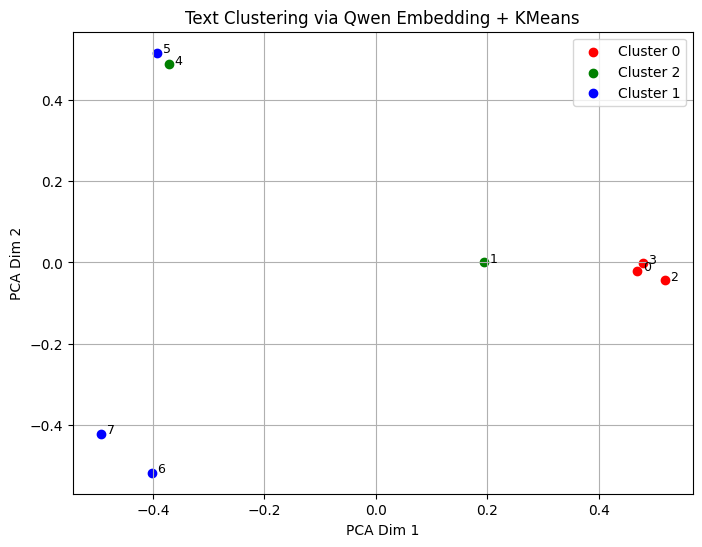

In [7]:
import torch
import torch.nn.functional as F 
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def last_token_pool(last_hidden_states, attention_mask):
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        batch_size = last_hidden_states.shape[0]
        sequence_index = attention_mask.sum(dim = 1) - 1
        return last_hidden_states[torch.arange(batch_size, device = last_hidden_states.device), sequence_index]
    

texts = [
    "The capital of China is Beijing.",
    "The Great Wall is a famous landmark in China.",
    "Paris is the capital of France.",
    "The Eiffel Tower is located in Paris.",
    "Apple releases a new iPhone every year.",
    "Samsung and Apple are leading smartphone brands.",
    "Quantum mechanics is a fundamental theory in physics.",
    "Newton's laws describe classical mechanics.",
]


model_path = '/home/xwj/Model/qwen3-embedding-0.6b'
tokenizer = AutoTokenizer.from_pretrained(model_path, padding_side='left')
model = AutoModel.from_pretrained(model_path)
model.eval()


for name, module in model.named_modules():
    print(name, module)


""" 
eod_id = tokenizer.convert_tokens_to_ids("<endoftext>")
batch_dict = tokenizer(texts, padding=False, truncation=True, max_length=512-2)
for ids, mask in zip(batch_dict["input_ids"], batch_dict["attention_mask"]):
    ids.append(eod_id)
    mask.append(1) 
batch_dict = tokenizer.pad(batch_dict, return_tensors="pt")
"""
input_texts = [text + " <|endoftext|>" for text in texts]
batch_dict = tokenizer(
    input_texts,
    padding=True,
    truncation=True,
    max_length=8192,
    return_tensors="pt"
)
batch_dict = {k: v.to(model.device) for k, v in batch_dict.items()}

with torch.no_grad():
    outputs = model(**batch_dict)
    embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)
print(f"embedding shape: {embeddings.shape}")

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings.cpu().numpy())


for i, (text, label) in enumerate(zip(texts, labels)):
    print(f"[Cluster {label}] {text}")

pca = PCA(n_components=2)
points_2d = pca.fit_transform(embeddings.cpu().numpy())
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i, (point, label) in enumerate(zip(points_2d, labels)):
    plt.scatter(point[0], point[1], color=colors[label], label=f"Cluster {label}" if f"Cluster {label}" not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.text(point[0]+0.01, point[1], f"{i}", fontsize=9)

plt.title("Text Clustering via Qwen Embedding + KMeans")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.legend()
plt.grid(True)
plt.show()
